In [89]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [90]:
# Data Reading

df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

# Data Processing

df = df[df["Escopo"] == "Total"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

list_of_companies = df.columns
list_of_companies = list(list_of_companies)
list_of_companies.remove("Years")

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

df_filtered = df[df.Years >= 2017]

display(df.head())
display(df.info())


Empresa,Years,Suzano,CSN,Intercement,Ternium Brasil,Votorantim,ArcelorMittal,CBA,ISA Energia
0,2008,1071559.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,734909.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1050928.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1369237.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,1355714.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Years           16 non-null     int64  
 1   Suzano          16 non-null     float64
 2   CSN             11 non-null     float64
 3   Intercement     11 non-null     float64
 4   Ternium Brasil  11 non-null     float64
 5   Votorantim      9 non-null      float64
 6   ArcelorMittal   7 non-null      float64
 7   CBA             7 non-null      float64
 8   ISA Energia     7 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 1.3 KB


None

In [91]:
# Auxiliaries Function


def applies_linear_regression(X, y, X_pred):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0
    return y_pred


def applies_autoregressive_model(data, p=0, d=0, q=0, steps_for_forec=1):
    model = ARIMA(data, order=(p, d, q)).fit()
    y_pred = model.forecast(steps=steps_for_forec)
    y_pred[y_pred < 0] = 0
    return y_pred


def get_rolling_values(ser, windows=3):
    ser = ser.rolling(windows).mean()    
    return ser.values

def generate_plot(company_name, X, y, X_pred, y_pred):
    (line,) = plt.plot(X, y, label=company_name)
    plt.plot(X_pred, y_pred, "o", color=line.get_color())

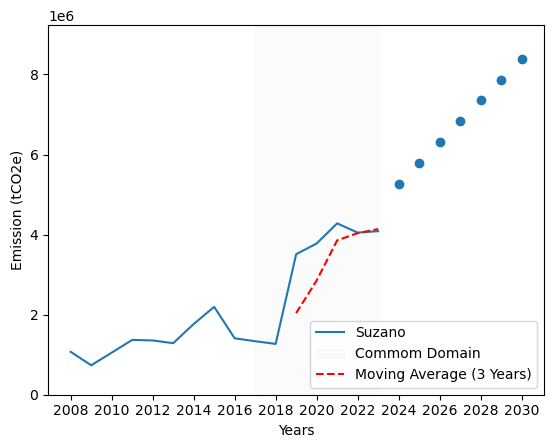

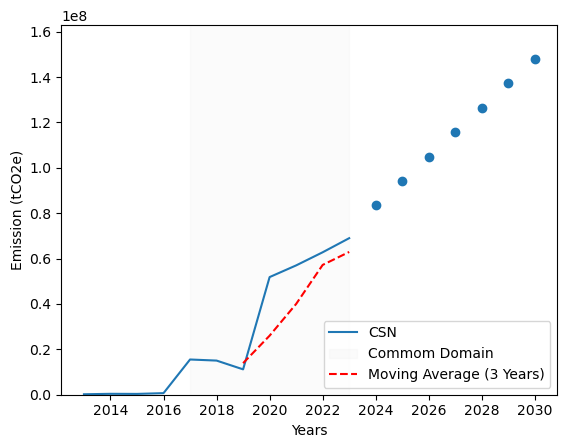

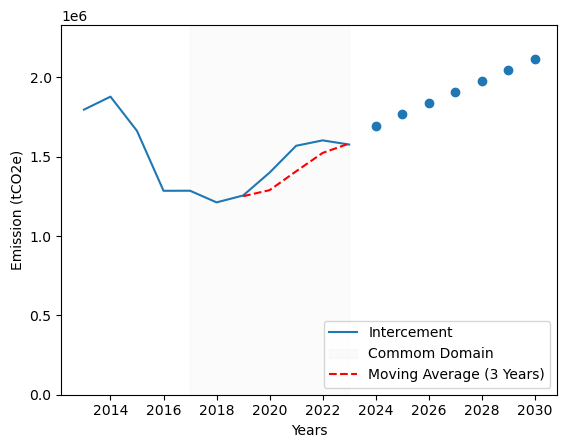

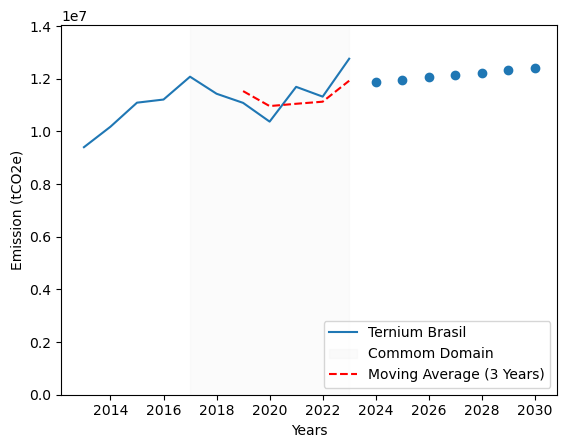

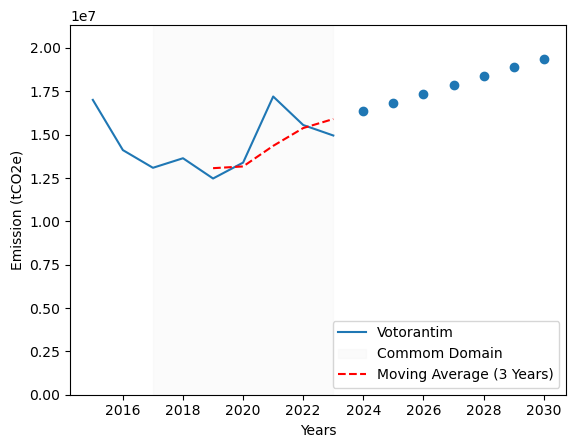

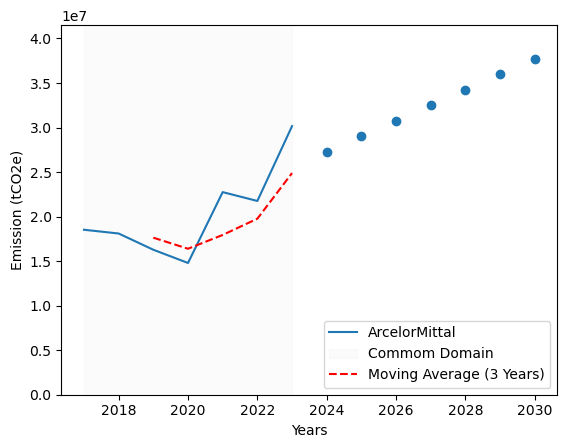

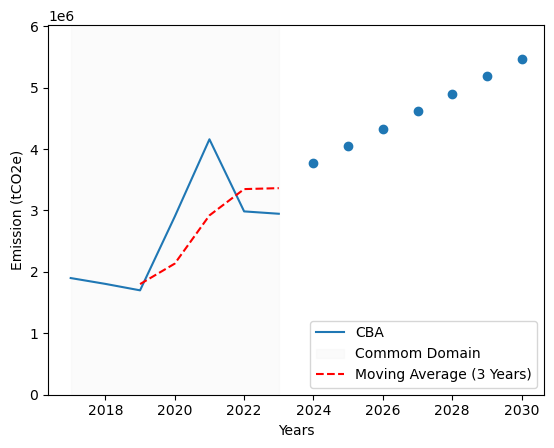

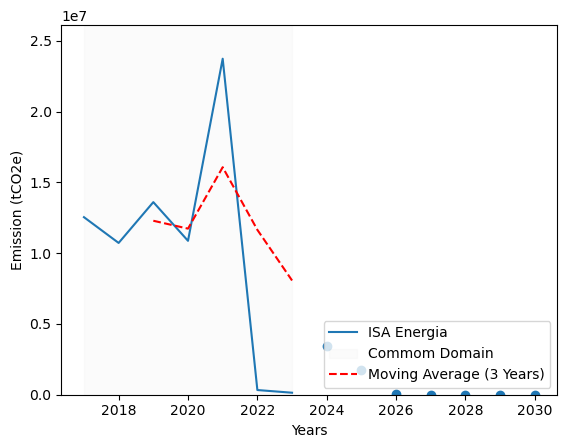

In [92]:
# Main

X_pred = np.array(range(2024, 2031))

# ARIMA Model
if False:
    for company_name in list_of_companies:
        p, d, q = 3, 0, 0

        X_train = df_filtered.Years.values
        y_train = df_filtered.loc[:, company_name].values

        y_pred = applies_autoregressive_model(
            y_train, p=p, d=d, q=q, steps_for_forec=len(X_pred)
        )

        X_plot = df.Years.values
        y_plot = df.loc[:, company_name].values

        X_plot = X_plot[~np.isnan(y_plot)]
        y_plot = y_plot[~np.isnan(y_plot)]

        plt.figure()
        generate_plot(company_name, X_plot, y_plot, X_pred, y_pred)
        plt.ylim([0, 1.1 * max(max(y_plot), max(y_pred))])
        plt.axvspan(
            min(X_train), max(X_train), color="gray", alpha=0.05, label="Commom Domain"
        )
        plt.legend(loc="lower right")
        plt.xlabel("Years")
        plt.ylabel("Emission (tCO2e)")
        # plt.savefig(f"../img/ARIMA(p={p}, d={d}, q={q}) - {company_name}", transparent=True, dpi=300)

# Linear Model
if True:
    for company_name in list_of_companies:
        # Processing Data

        X_train = df_filtered.Years.values
        y_train = df_filtered.loc[:, company_name].values

        X_rolling = X_train
        y_rolling = get_rolling_values(df_filtered.loc[:, company_name])
        X_rolling = X_train[~np.isnan(y_rolling)]
        y_rolling = y_rolling[~np.isnan(y_rolling)]

        y_pred = applies_linear_regression(X_train, y_train, X_pred)

        X_plot = df.Years.values
        y_plot = df.loc[:, company_name].values
        X_plot = X_plot[~np.isnan(y_plot)]
        y_plot = y_plot[~np.isnan(y_plot)]

        # Plot

        plt.figure()
        generate_plot(company_name, X_plot, y_plot, X_pred, y_pred)
        plt.axvspan(
            min(X_train), max(X_train), color="gray", alpha=0.03, label="Commom Domain"
        )
        plt.plot(X_rolling, y_rolling, "--r", label="Moving Average (3 Years)")
        
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(2))
        plt.ylim([0, 1.1 * max(max(y_plot), max(y_pred))])
        
        plt.legend(loc="lower right")
        plt.xlabel("Years")
        plt.ylabel("Emission (tCO2e)")
        plt.savefig(f"../img/Linear Model - {company_name}", transparent=True, dpi=300)